# 4501 Final Project
Team Members: Chongyi (Ian) Chie (cc4893) and Jinyu Qiao (jq2362)

Note: We worked on the code on our respective computers, and uploaded the code when we were done. We both contributed equally to the code.

## Part 1: Data Preprocessing


In [1]:
# Intalls packages required
import keplergl
import numpy as np
import math
import bs4
import pandas as pd
import requests
import sqlalchemy as db
import re
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import radians, cos, sin, asin, sqrt
from sqlalchemy import create_engine
from sqlalchemy import Column, Date, Integer, Float, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.schema import ForeignKey
from sqlalchemy import Table
from sqlalchemy.orm import relationship
import datetime 
from sqlalchemy.orm import sessionmaker
from sqlalchemy import func

### Download the data

In [2]:
# Obtain yellow taxi link
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

# Get the url of taxi
def get_taxi_html():
    response = requests.get(TAXI_URL)
    html = response.content
    return html

# Get every link of all yellow taxi trips data
def find_taxi_parquet_links():
    res = []
    soup = bs4.BeautifulSoup(get_taxi_html(), "html.parser")
    yellow = soup.find_all(title="Yellow Taxi Trip Records")
    for j in yellow:
        res.append(j['href'])
    return res
links = find_taxi_parquet_links()

In [ ]:
# Download taxi file with desired date with the link we obtain above and regex
from tqdm import tqdm
pattern =  "201[0-4]-\d\d|2009-\d\d|2015-0[0-6]"
for link in tqdm(links):
    date = re.findall(pattern,link)
    if len(date) != 0:
        r = requests.get(link)
        with open(f'./{date[0]}.parquet', 'wb') as f:
            f.write(r.content)

### Define the function to calculate the distance

In [3]:
# Function calculate crow distance for Uber and Taxi
def calculate_distance(from_coord, to_coord):
    lng1, lat1, lng2, lat2 = map(radians, [float(from_coord[0]), float(from_coord[1]), float(to_coord[0]), float(to_coord[1])])
    dlon = lng2 - lng1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2 
    distance = 2 * asin(sqrt(a)) * 6371 * 1000
    distance = round(distance / 1000, 3)
    return distance

### Uber Data Processing


In [4]:
# Clean the uber data
def process_uber_data():
    df = pd.read_csv("uber_rides_sample.csv")
    df.drop(labels='Unnamed: 0', axis=1, inplace=True)

    # filter out trips outside NYC region, with no passenger and zero fare
    df_filtered_uber = df[(df['pickup_latitude'] > 40.560445)
                    & (df['pickup_latitude'] < 40.908524)
                    & (df['dropoff_latitude'] > 40.560445)
                    & (df['dropoff_latitude'] < 40.908524)
                    & (df['pickup_longitude'] > -74.242330)
                    & (df['pickup_longitude'] < -73.717047)
                    & (df['dropoff_longitude'] > -74.242330)
                    & (df['dropoff_longitude'] < -73.717047)
                    & (df['passenger_count'] != 0)
                    & (df['fare_amount'] > 0)]

    # add new column datetime to determine day of week
    df_filtered_uber['datetime'] = df_filtered_uber['pickup_datetime'].str[0:10]
    df_filtered_uber['datetime'] = pd.to_datetime(df_filtered_uber['datetime'], format=r"%Y-%m-%d")
    df_filtered_uber['day_of_week'] = df_filtered_uber['datetime'].dt.day_name()

    # Split the original datetime into year, month and day
    df_filtered_uber['day'] = df_filtered_uber['pickup_datetime'].str[8:10]
    df_filtered_uber['month'] = df_filtered_uber['pickup_datetime'].str[5:7]
    df_filtered_uber['year'] = df_filtered_uber['pickup_datetime'].str[0:4]
    df_filtered_uber['year_month'] = df_filtered_uber['pickup_datetime'].str[0:7]

    # Calculation of monthly trip counts based on month for later sampling taxi data
    df_uber_countbymonth  = df_filtered_uber.groupby("year_month").count()
    df_uber_countbymonth['key'] = df_uber_countbymonth['key'].astype('int')

    # Calculate crow distance
    df_filtered_uber['from_coord'] = list(zip(df_filtered_uber["pickup_longitude"], df_filtered_uber["pickup_latitude"]))
    df_filtered_uber['to_coord'] = list(zip(df_filtered_uber["dropoff_longitude"], df_filtered_uber["dropoff_latitude"]))
    df_filtered_uber['coord_distance'] = df_filtered_uber.apply(lambda x: calculate_distance(x["from_coord"], x["to_coord"]), axis=1) 

    # Finalize columns
    df_filtered_uber = df_filtered_uber.drop(
                        columns=[
                            "from_coord","to_coord"
                            ]
                        )
    return df_filtered_uber, df_uber_countbymonth

In [5]:
# Out put of the cleaned uber data
(df_filtered_uber, df_uber_countbymonth) = process_uber_data()
df_filtered_uber.to_csv("df_filtered_uber.csv")
df_filtered_uber
df_uber_countbymonth

C:\Users\ianch\AppData\Local\Temp\ipykernel_1064\3992742065.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_uber['datetime'] = df_filtered_uber['pickup_datetime'].str[0:10]
C:\Users\ianch\AppData\Local\Temp\ipykernel_1064\3992742065.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_uber['datetime'] = pd.to_datetime(df_filtered_uber['datetime'], format=r"%Y-%m-%d")
C:\Users\ianch\AppData\Local\Temp\ipykernel_1064\3992742065.py:21: SettingWithCopyWarning: 
A value is trying to 

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,datetime,day_of_week,day,month,year
year_month,,,,,,,,,,,,,
2009-01,2503,2503,2503,2503,2503,2503,2503,2503,2503,2503,2503,2503,2503
2009-02,2261,2261,2261,2261,2261,2261,2261,2261,2261,2261,2261,2261,2261
2009-03,2665,2665,2665,2665,2665,2665,2665,2665,2665,2665,2665,2665,2665
2009-04,2531,2531,2531,2531,2531,2531,2531,2531,2531,2531,2531,2531,2531
2009-05,2619,2619,2619,2619,2619,2619,2619,2619,2619,2619,2619,2619,2619
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02,2165,2165,2165,2165,2165,2165,2165,2165,2165,2165,2165,2165,2165
2015-03,2322,2322,2322,2322,2322,2322,2322,2322,2322,2322,2322,2322,2322
2015-04,2300,2300,2300,2300,2300,2300,2300,2300,2300,2300,2300,2300,2300


### Yellow Taxi Data Processing


##### a. Yellow Taxi Zone Data Processing


In [6]:
# Use geopandaas to map the area ID and the location
import geopandas as gpd
shapefile = gpd.read_file(r".\taxi_zones\taxi_zones.shp")
shapefile.to_csv('taxi_zone.csv')
shapefile = shapefile.to_crs(4326)
shapefile['lon'] = shapefile.centroid.x 
shapefile['lat'] = shapefile.centroid.y
shapefile_PULocationID = shapefile.drop(
    columns=[
        'OBJECTID', 
        'Shape_Leng',
        'Shape_Area',
        'zone',
        'borough',
        'geometry'
        ]
    ).rename(columns={'LocationID': 'PULocationID'})
shapefile_DOLocationID = shapefile_PULocationID.rename(columns={'PULocationID': 'DOLocationID'})
shapefile_DOLocationID

C:\Users\ianch\AppData\Local\Temp\ipykernel_1064\2667059335.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shapefile['lon'] = shapefile.centroid.x
C:\Users\ianch\AppData\Local\Temp\ipykernel_1064\2667059335.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shapefile['lat'] = shapefile.centroid.y


,DOLocationID,lon,lat
0,1,-74.174000,40.691831
1,2,-73.831299,40.616745
2,3,-73.847422,40.864474
3,4,-73.976968,40.723752
4,5,-74.188484,40.552659
...,...,...,...
258,259,-73.852215,40.897932
259,260,-73.906306,40.744235
260,261,-74.013023,40.709139
261,262,-73.946510,40.775932


#### b. Clean and Merge Yellow Taxi Data

In [7]:
# Define the function to remove the invalid data
def remove_invalid_data(df):
    df_filtered = df[(df['Start_Lat'] > 40.560445)
                    & (df['Start_Lat'] < 40.908524)
                    & (df['End_Lat'] > 40.560445)
                    & (df['End_Lat'] < 40.908524)
                    & (df['Start_Lon'] > -74.242330)
                    & (df['Start_Lon'] < -73.717047)
                    & (df['End_Lon'] > -74.242330)
                    & (df['End_Lon'] < -73.717047)
                    & (df['Passenger_Count'] > 0)
                    & (df['Fare_Amt'] > 0)
                    & (df['Trip_Distance'] > 0)]
    return df_filtered

In [8]:
# Clean the data of 2009
def get_cleaned_data_2009():
        months =["01", "02", "03", "04", "05", "06", "07", "08", "09" ,"10", "11", "12"]
        dfs  = []
        for month in months:
                df = pd.DataFrame()
                df= pd.read_parquet(f"./2009-{month}.parquet", engine='auto')
                df_columns = df[["Trip_Pickup_DateTime", 
                                "Trip_Dropoff_DateTime", 
                                'Passenger_Count',
                                "Trip_Distance", 
                                "Start_Lon", 
                                "Start_Lat", 
                                "End_Lon", 
                                "End_Lat",
                                "Fare_Amt",
                                "Tip_Amt"]]
                df_columns_filtered = remove_invalid_data(df_columns)
                df_sample = df_columns_filtered.sample(n=df_uber_countbymonth.loc[f'2009-{month}','key'])
                dfs.append(df_sample)
        merged_df = pd.concat(dfs)
        return merged_df

In [9]:
result09 = get_cleaned_data_2009()
result09.head()

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Tip_Amt
8396614,2009-01-09 17:29:00,2009-01-09 17:36:00,2,1.31,-73.971575,40.750272,-73.975762,40.735745,6.1,0.0
7967796,2009-01-18 12:54:00,2009-01-18 13:02:00,1,2.88,-73.982253,40.735908,-73.980993,40.766840,9.3,2.0
11433079,2009-01-08 06:46:40,2009-01-08 06:54:33,1,1.90,-73.995132,40.739961,-73.975850,40.755212,7.3,0.0
5417479,2009-01-21 12:12:07,2009-01-21 12:15:42,3,0.40,-73.958487,40.775358,-73.964544,40.773976,4.1,0.0
13268802,2009-01-03 14:18:00,2009-01-03 14:26:00,1,0.93,-74.003757,40.738712,-73.991702,40.731333,6.1,0.0


In [10]:
# Clean the data of 2010
def get_cleaned_data_2010():    
        months =["01", "02", "03", "04", "05", "06", "07", "08", "09" ,"10", "11", "12"]
        dfs  = []
        for month in months:
            df = pd.read_parquet(f"./Taxi Data/2010-{month}.parquet", engine='auto')
            df_columns = df.drop(
                        columns=[
                            'vendor_id', 
                            'rate_code',
                            'store_and_fwd_flag',
                            'payment_type',
                            'surcharge','mta_tax','tolls_amount',
                            'total_amount'
                            ]
                        )
            df_columns_rename = df_columns.rename(columns={'pickup_datetime':'Trip_Pickup_DateTime',
                                            'dropoff_datetime':'Trip_Dropoff_DateTime',
                                            'passenger_count':'Passenger_Count',
                                            'trip_distance' :'Trip_Distance',
                                            'tip_amount': 'Tip_Amt',
                                            'fare_amount':'Fare_Amt',
                                            'pickup_longitude':'Start_Lon',
                                            'pickup_latitude':'Start_Lat',
                                            'dropoff_longitude': 'End_Lon',
                                            'dropoff_latitude':'End_Lat'
                                            })
            df_columns_filtered = remove_invalid_data(df_columns_rename)
            df_sample = df_columns_filtered.sample(n=df_uber_countbymonth.loc[f'2010-{month}','key'])
            dfs.append(df_sample)
        merged_df = pd.concat(dfs)
        
        return merged_df

In [11]:
result10 = get_cleaned_data_2010()
result10

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Tip_Amt
4655481,2010-01-19 07:54:00,2010-01-19 08:07:00,1,1.84,-73.952102,40.770258,-73.975847,40.764227,8.9,2.0
2303441,2010-01-18 22:24:00,2010-01-18 22:29:00,1,0.87,-73.979098,40.760280,-73.968488,40.758243,4.9,0.0
14348132,2010-01-21 13:46:00,2010-01-21 13:51:00,1,0.77,-74.003358,40.713600,-73.995555,40.721700,4.9,1.2
7583972,2010-01-31 17:19:18,2010-01-31 17:27:46,2,1.90,-73.986646,40.761819,-73.972415,40.785714,7.3,1.0
815062,2010-01-13 14:45:53,2010-01-13 15:00:48,1,1.70,-73.984212,40.761519,-73.982655,40.742107,9.3,0.0
...,...,...,...,...,...,...,...,...,...,...
682798,2010-12-20 10:42:38,2010-12-20 11:04:01,1,10.20,-73.980493,40.730565,-73.865313,40.770778,23.7,4.0
4882120,2010-12-19 05:41:26,2010-12-19 06:11:05,1,8.60,-73.982579,40.723142,-73.965438,40.795757,23.7,0.0
283727,2010-12-11 12:08:49,2010-12-11 12:11:16,1,1.00,-73.973123,40.744277,-73.963648,40.755999,4.5,0.0
544767,2010-12-14 15:22:04,2010-12-14 15:37:29,1,0.70,-73.980779,40.760165,-73.970032,40.762854,8.5,0.0


In [12]:
# Clean the data of 2011
def get_cleaned_data_2011():
    dfs  = []
    months =["01", "02", "03", "04", "05", "06", "07", "08", "09" ,"10", "11", "12"]      
    for month in months:
        df = pd.DataFrame()
        df = pd.read_parquet(f"./Taxi Data/2011-{month}.parquet", engine='auto')
        df_columns = df.drop(
            columns=[
                'VendorID', 
                'RatecodeID',
                'store_and_fwd_flag',
                'payment_type',
                'extra','mta_tax','tolls_amount',
                'tolls_amount','improvement_surcharge','congestion_surcharge','airport_fee','total_amount'
                ]
            )
        df_PUlonlat = pd.merge(df_columns,shapefile_PULocationID,how = 'inner',on = ['PULocationID']).rename(columns={'lon': 'Start_Lon','lat':'Start_Lat'})
        df_Bothlonlat = pd.merge(df_PUlonlat,shapefile_DOLocationID,how = 'inner',on = ['DOLocationID']).rename(
        columns={'tpep_pickup_datetime':'Trip_Pickup_DateTime',
        'tpep_dropoff_datetime':'Trip_Dropoff_DateTime',
        'passenger_count':'Passenger_Count',
        'trip_distance' :'Trip_Distance',
        'tip_amount':'Tip_Amt',
        'fare_amount':'Fare_Amt',
        'lon': 'End_Lon',
        'lat':'End_Lat'
        }
        ).drop(
        columns=[
            'PULocationID',
            'DOLocationID'
            ]
        )
        df_Bothlonlat_filtered = remove_invalid_data(df_Bothlonlat)

        df_Bothlonlat_sample = df_Bothlonlat_filtered.sample(n=df_uber_countbymonth.loc[f'2011-{month}','key'])
        dfs.append(df_Bothlonlat_sample)
    merged_df = pd.concat(dfs)
    return merged_df

In [13]:
result11 = get_cleaned_data_2011()
result11

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Fare_Amt,Tip_Amt,Start_Lon,Start_Lat,End_Lon,End_Lat
11849919,2011-01-29 21:55:15,2011-01-29 21:56:31,1,0.20,2.9,0.00,-73.990458,40.740337,-73.990458,40.740337
6710099,2011-01-05 23:08:23,2011-01-05 23:25:22,2,3.50,12.1,3.00,-73.997380,40.728340,-73.989845,40.762253
6365912,2011-01-06 23:04:00,2011-01-06 23:11:00,5,1.57,6.5,1.00,-74.002875,40.734576,-73.984052,40.736824
6259984,2011-01-11 08:40:41,2011-01-11 08:57:08,1,2.40,10.5,0.00,-73.992438,40.748497,-73.965635,40.768615
12368362,2011-01-21 01:12:33,2011-01-21 01:33:46,1,8.40,20.9,3.28,-74.004015,40.753309,-73.863339,40.726156
...,...,...,...,...,...,...,...,...,...,...
11790557,2011-12-03 02:50:24,2011-12-03 03:09:12,1,4.90,14.9,3.18,-73.990896,40.718938,-73.981532,40.773633
6568501,2011-12-02 20:32:00,2011-12-02 20:39:00,1,1.15,5.7,1.20,-74.007880,40.717773,-74.007496,40.706808
6661170,2011-12-04 20:43:28,2011-12-04 20:51:12,3,1.50,6.1,0.00,-74.002875,40.734576,-73.999917,40.748428
14136844,2011-12-25 00:27:00,2011-12-25 00:57:00,1,11.05,27.3,0.00,-73.988787,40.753513,-73.988661,40.630950


In [14]:
# Clean the data of 2012
def get_cleaned_data_2012():
    dfs  = []
    months =["01", "02", "03", "04", "05", "06", "07", "08", "09" ,"10", "11", "12"]      
    for month in months:
        df = pd.DataFrame()
        df = pd.read_parquet(f"./Taxi Data/2012-{month}.parquet", engine='auto')
        df_columns = df.drop(
            columns=[
                'VendorID', 
                'RatecodeID',
                'store_and_fwd_flag',
                'payment_type',
                'extra','mta_tax','tolls_amount',
                'tolls_amount','improvement_surcharge','congestion_surcharge','airport_fee','total_amount'
                ]
            )
        df_PUlonlat = pd.merge(df_columns,shapefile_PULocationID,how = 'inner',on = ['PULocationID']).rename(columns={'lon': 'Start_Lon','lat':'Start_Lat'})
        df_Bothlonlat = pd.merge(df_PUlonlat,shapefile_DOLocationID,how = 'inner',on = ['DOLocationID']).rename(
        columns={'tpep_pickup_datetime':'Trip_Pickup_DateTime',
        'tpep_dropoff_datetime':'Trip_Dropoff_DateTime',
        'passenger_count':'Passenger_Count',
        'trip_distance' :'Trip_Distance',
        'tip_amount':'Tip_Amt',
        'fare_amount':'Fare_Amt',
        'lon': 'End_Lon',
        'lat':'End_Lat'
        }
        ).drop(
        columns=[
            'PULocationID',
            'DOLocationID'
            ]
        )
        df_Bothlonlat_filtered = remove_invalid_data(df_Bothlonlat)

        df_Bothlonlat_sample = df_Bothlonlat_filtered.sample(n=df_uber_countbymonth.loc[f'2012-{month}','key'])
        dfs.append(df_Bothlonlat_sample)
    merged_df = pd.concat(dfs)
    return merged_df

In [15]:
result12 = get_cleaned_data_2012()
result12

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Fare_Amt,Tip_Amt,Start_Lon,Start_Lat,End_Lon,End_Lat
2755970,2012-01-08 00:36:15,2012-01-08 00:40:20,1,0.90,4.9,0.00,-73.984052,40.736824,-73.985937,40.727620
4057446,2012-01-11 14:13:00,2012-01-11 14:21:00,5,1.76,7.3,0.00,-73.978492,40.747746,-73.965635,40.768615
4124428,2012-01-20 10:21:30,2012-01-20 10:30:05,1,1.20,6.5,2.00,-73.951010,40.778766,-73.965635,40.768615
817336,2012-01-28 16:08:00,2012-01-28 16:18:00,5,3.56,10.5,0.00,-73.959635,40.766948,-73.976598,40.731821
10142706,2012-01-21 14:31:57,2012-01-21 14:58:19,1,14.60,32.5,6.08,-74.013023,40.709139,-73.858135,40.817859
...,...,...,...,...,...,...,...,...,...,...
7107277,2012-12-01 23:28:07,2012-12-01 23:35:58,1,1.20,7.0,0.00,-73.972356,40.756688,-73.978492,40.747746
5348053,2012-12-17 10:25:43,2012-12-17 10:30:58,1,1.20,6.0,1.30,-74.007486,40.726290,-73.996971,40.742279
6607957,2012-12-22 13:46:22,2012-12-22 13:49:06,1,0.60,4.5,0.00,-74.001538,40.723888,-74.002875,40.734576
11098902,2012-12-23 03:07:00,2012-12-23 03:20:00,5,3.13,12.5,0.00,-73.989845,40.762253,-73.973049,40.791705


In [16]:
# Clean the data of 2013
def get_cleaned_data_2013():
    dfs  = []
    months =["01", "02", "03", "04", "05", "06", "07", "08", "09" ,"10", "11", "12"]      
    for month in months:
        df = pd.DataFrame()
        df = pd.read_parquet(f"./Taxi Data/2013-{month}.parquet", engine='auto')
        df_columns = df.drop(
            columns=[
                'VendorID', 
                'RatecodeID',
                'store_and_fwd_flag',
                'payment_type',
                'extra','mta_tax','tolls_amount',
                'tolls_amount','improvement_surcharge','congestion_surcharge','airport_fee','total_amount'
                ]
            )
        df_PUlonlat = pd.merge(df_columns,shapefile_PULocationID,how = 'inner',on = ['PULocationID']).rename(columns={'lon': 'Start_Lon','lat':'Start_Lat'})
        df_Bothlonlat = pd.merge(df_PUlonlat,shapefile_DOLocationID,how = 'inner',on = ['DOLocationID']).rename(
        columns={'tpep_pickup_datetime':'Trip_Pickup_DateTime',
        'tpep_dropoff_datetime':'Trip_Dropoff_DateTime',
        'passenger_count':'Passenger_Count',
        'trip_distance' :'Trip_Distance',
        'tip_amount':'Tip_Amt',
        'fare_amount':'Fare_Amt',
        'lon': 'End_Lon',
        'lat':'End_Lat'
        }
        ).drop(
        columns=[
            'PULocationID',
            'DOLocationID'
            ]
        )
        df_Bothlonlat_filtered = remove_invalid_data(df_Bothlonlat)

        df_Bothlonlat_sample = df_Bothlonlat_filtered.sample(n=df_uber_countbymonth.loc[f'2013-{month}','key'])
        dfs.append(df_Bothlonlat_sample)
    merged_df = pd.concat(dfs)
    return merged_df

In [17]:
result13 = get_cleaned_data_2013()
result13

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Fare_Amt,Tip_Amt,Start_Lon,Start_Lat,End_Lon,End_Lat
5665573,2013-01-04 07:32:17,2013-01-04 07:46:23,1,3.10,13.0,2.00,-73.946510,40.775932,-73.977698,40.758028
6876053,2013-01-16 09:47:00,2013-01-16 09:55:19,1,0.80,7.0,0.00,-73.972356,40.756688,-73.978492,40.747746
1669086,2013-01-02 20:18:00,2013-01-02 20:39:00,1,5.67,20.0,5.12,-73.990458,40.740337,-73.951292,40.804334
1865498,2013-01-04 19:34:50,2013-01-04 19:41:52,1,1.80,7.5,0.00,-73.945750,40.790011,-73.973049,40.791705
5401626,2013-01-25 12:57:18,2013-01-25 12:59:29,1,0.50,4.0,1.00,-73.995135,40.766238,-73.987646,40.775965
...,...,...,...,...,...,...,...,...,...,...
2548474,2013-12-21 20:04:38,2013-12-21 20:26:13,3,3.40,15.5,0.00,-73.951010,40.778766,-73.984052,40.736824
2125113,2013-12-28 15:26:02,2013-12-28 15:45:11,4,5.10,18.0,4.62,-73.999917,40.748428,-73.951010,40.778766
3847994,2013-12-02 19:09:00,2013-12-02 19:21:00,1,2.08,10.5,1.00,-73.973049,40.791705,-73.957012,40.780436
1561315,2013-12-27 22:29:20,2013-12-27 22:36:35,2,0.90,6.5,1.87,-74.007880,40.717773,-74.016079,40.712038


In [18]:
# Clean the data of 2014
def get_cleaned_data_2014():
    dfs  = []
    months =["01", "02", "03", "04", "05", "06", "07", "08", "09" ,"10", "11", "12"]      
    for month in months:
        df = pd.DataFrame()
        df = pd.read_parquet(f"./Taxi Data/2014-{month}.parquet", engine='auto')
        df_columns = df.drop(
            columns=[
                'VendorID', 
                'RatecodeID',
                'store_and_fwd_flag',
                'payment_type',
                'extra','mta_tax','tolls_amount',
                'tolls_amount','improvement_surcharge','congestion_surcharge','airport_fee','total_amount'
                ]
            )
        df_PUlonlat = pd.merge(df_columns,shapefile_PULocationID,how = 'inner',on = ['PULocationID']).rename(columns={'lon': 'Start_Lon','lat':'Start_Lat'})
        df_Bothlonlat = pd.merge(df_PUlonlat,shapefile_DOLocationID,how = 'inner',on = ['DOLocationID']).rename(
        columns={'tpep_pickup_datetime':'Trip_Pickup_DateTime',
        'tpep_dropoff_datetime':'Trip_Dropoff_DateTime',
        'passenger_count':'Passenger_Count',
        'trip_distance' :'Trip_Distance',
        'tip_amount':'Tip_Amt',
        'fare_amount':'Fare_Amt',
        'lon': 'End_Lon',
        'lat':'End_Lat'
        }
        ).drop(
        columns=[
            'PULocationID',
            'DOLocationID'
            ]
        )
        df_Bothlonlat_filtered = remove_invalid_data(df_Bothlonlat)

        df_Bothlonlat_sample = df_Bothlonlat_filtered.sample(n=df_uber_countbymonth.loc[f'2014-{month}','key'])
        dfs.append(df_Bothlonlat_sample)
    merged_df = pd.concat(dfs)
    return merged_df

In [19]:
result14 = get_cleaned_data_2014()
result14

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Fare_Amt,Tip_Amt,Start_Lon,Start_Lat,End_Lon,End_Lat
6205797,2014-01-20 07:31:00,2014-01-20 07:33:00,5,0.41,3.5,0.88,-73.992438,40.748497,-73.989845,40.762253
4546607,2014-01-05 18:02:00,2014-01-05 18:20:00,6,8.78,26.0,0.00,-73.873629,40.774376,-73.984052,40.736824
9520407,2014-01-19 19:42:00,2014-01-19 19:58:00,2,4.90,17.0,4.25,-73.954739,40.765484,-73.940772,40.818258
627642,2014-01-30 08:38:32,2014-01-30 08:44:41,1,1.20,7.0,1.00,-73.924673,40.737699,-73.948891,40.745379
9128576,2014-01-15 09:32:00,2014-01-15 09:42:00,6,0.97,7.5,1.00,-73.989845,40.762253,-73.977698,40.758028
...,...,...,...,...,...,...,...,...,...,...
4296224,2014-12-27 16:54:50,2014-12-27 17:10:53,1,3.15,13.5,2.70,-73.977698,40.758028,-73.985937,40.727620
2387554,2014-12-26 18:22:27,2014-12-26 18:25:58,4,1.14,5.0,1.80,-73.965635,40.768615,-73.957012,40.780436
10980022,2014-12-30 12:06:02,2014-12-30 12:17:42,1,1.60,9.5,0.00,-73.965554,40.782478,-73.977569,40.764421
1977721,2014-12-12 09:31:03,2014-12-12 09:37:56,1,1.20,7.0,1.40,-73.996971,40.742279,-74.002875,40.734576


In [20]:
# Clean the data of 2015
def get_cleaned_data_2015():
    dfs  = []
    months =["01", "02", "03", "04", "05", "06"]      
    for month in months:
        df = pd.DataFrame()
        df = pd.read_parquet(f"./Taxi Data/2015-{month}.parquet", engine='auto')
        df_columns = df.drop(
            columns=[
                'VendorID', 
                'RatecodeID',
                'store_and_fwd_flag',
                'payment_type',
                'extra','mta_tax','tolls_amount',
                'tolls_amount','improvement_surcharge','congestion_surcharge','airport_fee','total_amount'
                ]
            )
        df_PUlonlat = pd.merge(df_columns,shapefile_PULocationID,how = 'inner',on = ['PULocationID']).rename(columns={'lon': 'Start_Lon','lat':'Start_Lat'})
        df_Bothlonlat = pd.merge(df_PUlonlat,shapefile_DOLocationID,how = 'inner',on = ['DOLocationID']).rename(
        columns={'tpep_pickup_datetime':'Trip_Pickup_DateTime',
        'tpep_dropoff_datetime':'Trip_Dropoff_DateTime',
        'passenger_count':'Passenger_Count',
        'trip_distance' :'Trip_Distance',
        'tip_amount':'Tip_Amt',
        'fare_amount':'Fare_Amt',
        'lon': 'End_Lon',
        'lat':'End_Lat'
        }
        ).drop(
        columns=[
            'PULocationID',
            'DOLocationID'
            ]
        )
        df_Bothlonlat_filtered = remove_invalid_data(df_Bothlonlat)

        df_Bothlonlat_sample = df_Bothlonlat_filtered.sample(n=df_uber_countbymonth.loc[f'2015-{month}','key'])
        dfs.append(df_Bothlonlat_sample)
    merged_df = pd.concat(dfs)
    return merged_df

In [21]:
result15 = get_cleaned_data_2015()
result15

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Fare_Amt,Tip_Amt,Start_Lon,Start_Lat,End_Lon,End_Lat
3194774,2015-01-30 08:06:03,2015-01-30 08:10:26,1,0.60,5.0,0.00,-73.981532,40.773633,-73.987646,40.775965
3306529,2015-01-05 11:12:11,2015-01-05 11:21:00,1,1.73,8.5,2.12,-73.957012,40.780436,-73.965635,40.768615
507753,2015-01-20 11:19:36,2015-01-20 11:30:28,1,0.90,8.0,0.00,-73.977569,40.764421,-73.977698,40.758028
7429752,2015-01-31 10:49:36,2015-01-31 10:55:44,1,0.90,6.0,0.00,-73.981532,40.773633,-73.978632,40.783961
8377732,2015-01-11 08:36:03,2015-01-11 08:44:49,1,1.26,7.5,2.00,-73.978492,40.747746,-74.004015,40.753309
...,...,...,...,...,...,...,...,...,...,...
8707614,2015-06-01 18:29:38,2015-06-01 18:49:24,1,2.18,13.5,3.06,-73.978492,40.747746,-73.997380,40.728340
9724005,2015-06-01 19:16:42,2015-06-01 19:22:36,1,0.40,5.5,1.46,-73.965554,40.782478,-73.965635,40.768615
12048503,2015-06-17 00:43:27,2015-06-17 00:48:33,1,3.11,10.5,0.00,-73.786533,40.646985,-73.764506,40.662185
1124717,2015-06-06 12:57:41,2015-06-06 13:09:43,1,1.18,8.5,1.00,-73.985156,40.748575,-73.984052,40.736824


In [22]:
# Merge all sampled taxi data together
merged_df_final = pd.concat([result09,result10,result11,result12,result13,result14,result15])
merged_df_final

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Tip_Amt
8396614,2009-01-09 17:29:00,2009-01-09 17:36:00,2,1.31,-73.971575,40.750272,-73.975762,40.735745,6.1,0.00
7967796,2009-01-18 12:54:00,2009-01-18 13:02:00,1,2.88,-73.982253,40.735908,-73.980993,40.766840,9.3,2.00
11433079,2009-01-08 06:46:40,2009-01-08 06:54:33,1,1.90,-73.995132,40.739961,-73.975850,40.755212,7.3,0.00
5417479,2009-01-21 12:12:07,2009-01-21 12:15:42,3,0.40,-73.958487,40.775358,-73.964544,40.773976,4.1,0.00
13268802,2009-01-03 14:18:00,2009-01-03 14:26:00,1,0.93,-74.003757,40.738712,-73.991702,40.731333,6.1,0.00
...,...,...,...,...,...,...,...,...,...,...
8707614,2015-06-01 18:29:38,2015-06-01 18:49:24,1,2.18,-73.978492,40.747746,-73.997380,40.728340,13.5,3.06
9724005,2015-06-01 19:16:42,2015-06-01 19:22:36,1,0.40,-73.965554,40.782478,-73.965635,40.768615,5.5,1.46
12048503,2015-06-17 00:43:27,2015-06-17 00:48:33,1,3.11,-73.786533,40.646985,-73.764506,40.662185,10.5,0.00
1124717,2015-06-06 12:57:41,2015-06-06 13:09:43,1,1.18,-73.985156,40.748575,-73.984052,40.736824,8.5,1.00


In [23]:
# calculate distance and add year, month, day, hour
merged_df_final['from_coord'] = list(zip(merged_df_final["Start_Lon"], merged_df_final["Start_Lat"]))
merged_df_final['to_coord'] = list(zip(merged_df_final["End_Lon"], merged_df_final["End_Lat"]))
merged_df_final['coord_distance'] = merged_df_final.apply(lambda x: calculate_distance(x["from_coord"], x["to_coord"]), axis=1) 
merged_df_final = merged_df_final.drop(
                        columns=[
                            "from_coord","to_coord"
                            ]
                        )

merged_df_final['Trip_Pickup_DateTime'] = merged_df_final['Trip_Pickup_DateTime'].astype('str')
merged_df_final['date'] = merged_df_final['Trip_Pickup_DateTime'].str[0:10]

In [24]:
# Calculate the day of week
merged_df_final['date'] = pd.to_datetime(merged_df_final['date'], format=r"%Y-%m-%d")
merged_df_final['day_of_week'] = merged_df_final['date'].dt.day_name()

# Define the new columns
merged_df_final['HOUR'] = merged_df_final['Trip_Pickup_DateTime'].str[-8:-6]
merged_df_final['day'] = merged_df_final['Trip_Pickup_DateTime'].str[8:10]
merged_df_final['month'] = merged_df_final['Trip_Pickup_DateTime'].str[5:7]
merged_df_final['year'] = merged_df_final['Trip_Pickup_DateTime'].str[0:4]
merged_df_final['year_month'] = merged_df_final['Trip_Pickup_DateTime'].str[0:7]
merged_df_final.head(10)

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Tip_Amt,coord_distance,date,day_of_week,HOUR,day,month,year,year_month
8396614,2009-01-09 17:29:00,2009-01-09 17:36:00,2,1.31,-73.971575,40.750272,-73.975762,40.735745,6.1,0.0,1.653,2009-01-09,Friday,17,09,01,2009,2009-01
7967796,2009-01-18 12:54:00,2009-01-18 13:02:00,1,2.88,-73.982253,40.735908,-73.980993,40.766840,9.3,2.0,3.441,2009-01-18,Sunday,12,18,01,2009,2009-01
11433079,2009-01-08 06:46:40,2009-01-08 06:54:33,1,1.90,-73.995132,40.739961,-73.975850,40.755212,7.3,0.0,2.348,2009-01-08,Thursday,06,08,01,2009,2009-01
5417479,2009-01-21 12:12:07,2009-01-21 12:15:42,3,0.40,-73.958487,40.775358,-73.964544,40.773976,4.1,0.0,0.533,2009-01-21,Wednesday,12,21,01,2009,2009-01
13268802,2009-01-03 14:18:00,2009-01-03 14:26:00,1,0.93,-74.003757,40.738712,-73.991702,40.731333,6.1,0.0,1.306,2009-01-03,Saturday,14,03,01,2009,2009-01
13318564,2009-01-08 13:43:00,2009-01-08 14:27:00,5,18.80,-74.000887,40.731757,-73.789605,40.647013,45.0,0.0,20.153,2009-01-08,Thursday,13,08,01,2009,2009-01
6832924,2009-01-31 21:19:00,2009-01-31 21:23:00,5,1.08,-73.968610,40.754128,-73.978865,40.743605,4.5,0.0,1.454,2009-01-31,Saturday,21,31,01,2009,2009-01
9114502,2009-01-23 21:39:14,2009-01-23 21:47:49,2,1.00,-73.965349,40.761865,-73.980275,40.765106,6.6,0.0,1.308,2009-01-23,Friday,21,23,01,2009,2009-01
5917187,2009-01-28 18:57:25,2009-01-28 19:11:06,3,1.50,-73.968558,40.754684,-73.989664,40.751347,8.1,0.0,1.816,2009-01-28,Wednesday,18,28,01,2009,2009-01
12186393,2009-01-29 12:20:00,2009-01-29 12:27:00,1,0.63,-73.961087,40.769048,-73.960728,40.775797,5.3,0.0,0.751,2009-01-29,Thursday,12,29,01,2009,2009-01


### Weather Data Processing

In [25]:
# Read the weather data
weather_years = ["2009", "2010", "2011", "2012", "2013", "2014", "2015"]
df_weather = pd.DataFrame()
for year in weather_years:
    fpath = "./weather/"+year+"_weather.csv"
    df_ori = pd.read_csv(fpath, usecols=['DATE','HourlyPrecipitation','HourlyWindSpeed','DailySustainedWindSpeed'])
    df_temp = df_ori
    df_weather = pd.concat([df_weather, df_temp])

In [26]:
# Substitute NaN with 0
df_weather.fillna(0, inplace=True)

In [27]:
# Substitute the T
df_weather["HourlyPrecipitation"] = np.where(df_weather["HourlyPrecipitation"]=="T",0.0000001,df_weather["HourlyPrecipitation"])

# Define the new columns
df_weather['HOUR'] = df_weather['DATE'].str[11:13]
df_weather['day'] = df_weather['DATE'].str[8:10]
df_weather['month'] = df_weather['DATE'].str[5:7]
df_weather['year'] = df_weather['DATE'].str[0:4]
df_weather['datetime'] = df_weather['DATE'].str[0:10]

In [28]:
df_weather['HourlyPrecipitation'] = pd.to_numeric(df_weather['HourlyPrecipitation'],errors='coerce')

In [29]:
# Calculate the daily and hourly weather data
df_weather_hourly= df_weather.groupby(['datetime', 'HOUR']).agg({'HourlyPrecipitation':'sum','HourlyWindSpeed':'mean', 'DailySustainedWindSpeed':"sum"})
df_weather_daily = df_weather.groupby(['datetime']).agg({'HourlyPrecipitation':'sum','HourlyWindSpeed':'mean'})
df_weather_daily.rename(columns={"HourlyPrecipitation": "DailyPrecipitation", "HourlyWindSpeed": "DailyWindSpeed"},inplace=True)
df_weather_hourly

HourlyPrecipitation  HourlyWindSpeed  DailySustainedWindSpeed
datetime   HOUR                                                               
2009-01-01 00                    0.0        18.000000                      0.0
           01                    0.0        18.000000                      0.0
           02                    0.0        18.000000                      0.0
           03                    0.0         8.000000                      0.0
           04                    0.0        11.000000                      0.0
...                              ...              ...                      ...
2015-12-31 19                    0.0         6.000000                      0.0
           20                    0.0        10.000000                      0.0
           21                    0.0         0.000000                      0.0
           22                    0.0         7.000000                      0.0
           23                    0.0         1.666667                     14.0

[60458 rows x 3 columns]

## Part 2: Storing Data




In [30]:
# Set up the database
engine = create_engine(f"sqlite:///contacts.db", echo=True)
Base = declarative_base()
Base.metadata.create_all(engine, checkfirst=True)

2022-12-11 18:58:49,853 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:58:49,854 INFO sqlalchemy.engine.Engine COMMIT


In [31]:
merged_df_final.to_csv("merged_df_final.csv")
df_yt_final = pd.read_csv("merged_df_final.csv")

In [32]:
df_yt_final.drop(['Unnamed: 0'], axis=1, inplace=True)

### Yellow Taxi Trip Table


In [33]:
# Create the yellow taxi trip table
class Yellow_Taxi_trip(Base):
    
    __tablename__ = "Yellow_Taxi_trips"
    
    id = Column(Integer, primary_key=True)
    Trip_Pickup_DateTime = Column(String)
    Trip_Dropoff_DateTime = Column(String)
    Passenger_Count = Column(Integer)
    Trip_Distance = Column(Float)
    Start_Lon = Column(Float)
    Start_Lat = Column(Float)
    End_Lon = Column(Float)
    End_Lat = Column(Float)
    Fare_Amt = Column(Float)
    Tip_Amt = Column(Float)
    coord_distance = Column(Float)
    day_of_week = Column(String)
    HOUR = Column(String)
    day = Column(String)
    month = Column(String)
    year = Column(String)
    year_month = Column(String)

In [34]:
df_yt_final.to_sql('Yellow_Taxi_trip', engine)

2022-12-11 18:58:54,486 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Yellow_Taxi_trip")
2022-12-11 18:58:54,486 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:58:54,487 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Yellow_Taxi_trip")
2022-12-11 18:58:54,488 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:58:54,491 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:58:54,492 INFO sqlalchemy.engine.Engine 
CREATE TABLE "Yellow_Taxi_trip" (
	"index" BIGINT, 
	"Trip_Pickup_DateTime" TEXT, 
	"Trip_Dropoff_DateTime" TEXT, 
	"Passenger_Count" BIGINT, 
	"Trip_Distance" FLOAT, 
	"Start_Lon" FLOAT, 
	"Start_Lat" FLOAT, 
	"End_Lon" FLOAT, 
	"End_Lat" FLOAT, 
	"Fare_Amt" FLOAT, 
	"Tip_Amt" FLOAT, 
	coord_distance FLOAT, 
	date TEXT, 
	day_of_week TEXT, 
	"HOUR" BIGINT, 
	day BIGINT, 
	month BIGINT, 
	year BIGINT, 
	year_month TEXT
)


2022-12-11 18:58:54,493 INFO sqlalchemy.engine.Engine [no key 0.00055s] ()
2022-12-11 18:58:54,507 INFO sqlalchemy.engi

194769

### Uber Table

In [35]:
# Create the tabel of the uber trip
class Uber_trip(Base):
    
    __tablename__ = "Uber_trips"
    __table_args__ = {'extend_existing': True}
    
    id = Column(Integer, primary_key=True)
    fare_amount = Column(Float)
    pickup_datetime = Column(Date)
    pickup_longitude = Column(Float)
    pickup_latitude = Column(Float)
    dropoff_longitude = Column(Float)
    dropoff_latitude = Column(Float)
    passenger_count = Column(Integer)
    date = Column(Date)
    month = Column(Date)
    day_of_week = Column(String)
    coord_distance = Column(Float)
    day_of_week = Column(String)
    HOUR = Column(String)
    day = Column(String)
    month = Column(String)
    year = Column(String)
    year_month = Column(String)

In [36]:
df_filtered_uber.to_sql('Uber_trip', engine)

2022-12-11 18:58:58,065 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Uber_trip")
2022-12-11 18:58:58,065 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:58:58,066 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Uber_trip")
2022-12-11 18:58:58,067 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:58:58,070 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:58:58,071 INFO sqlalchemy.engine.Engine 
CREATE TABLE "Uber_trip" (
	"index" BIGINT, 
	"key" TEXT, 
	fare_amount FLOAT, 
	pickup_datetime TEXT, 
	pickup_longitude FLOAT, 
	pickup_latitude FLOAT, 
	dropoff_longitude FLOAT, 
	dropoff_latitude FLOAT, 
	passenger_count BIGINT, 
	datetime DATETIME, 
	day_of_week TEXT, 
	day TEXT, 
	month TEXT, 
	year TEXT, 
	year_month TEXT, 
	coord_distance FLOAT
)


2022-12-11 18:58:58,071 INFO sqlalchemy.engine.Engine [no key 0.00048s] ()
2022-12-11 18:58:58,080 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_Uber_trip_index" ON "Uber_trip" ("index")
2022-12-11 18

194769

### Hourly Weather Data Table 

In [37]:
# Create the hourly data Table
class hourly_weather(Base):
    
    __tablename__ = "hourly_weather"
    
    id = Column(Integer, primary_key=True)
    DAY = Column(Date)
    HOUR = Column(Integer)
    HourlyPrecipitation = Column(Float)
    HourlyWindSpeed = Column(Float)

In [38]:
df_weather_hourly.to_sql('hourly_weather', engine)

2022-12-11 18:59:02,147 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("hourly_weather")
2022-12-11 18:59:02,148 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:59:02,149 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("hourly_weather")
2022-12-11 18:59:02,150 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:59:02,152 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:59:02,152 INFO sqlalchemy.engine.Engine 
CREATE TABLE hourly_weather (
	datetime TEXT, 
	"HOUR" TEXT, 
	"HourlyPrecipitation" FLOAT, 
	"HourlyWindSpeed" FLOAT, 
	"DailySustainedWindSpeed" FLOAT
)


2022-12-11 18:59:02,153 INFO sqlalchemy.engine.Engine [no key 0.00065s] ()
2022-12-11 18:59:02,162 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_hourly_weather_HOUR" ON hourly_weather ("HOUR")
2022-12-11 18:59:02,163 INFO sqlalchemy.engine.Engine [no key 0.00063s] ()
2022-12-11 18:59:02,171 INFO sqlalchemy.engine.Engine CREATE INDEX ix_hourly_weather_datetime ON hourly_weather (datetime)
2

60458

### Daily Weather Data Table

In [39]:
# Create the weather data Table
class daily_weather(Base):
    
    __tablename__ = "daily_weather"
    
    id = Column(Integer, primary_key=True)
    DAY = Column(Date)
    DailyPrecipitation = Column(Float)
    DailyWindSpeed = Column(Float)
    DailySustainedWindSpeed = Column(Float)

In [40]:
df_weather_daily.to_sql('daily_weather', engine)

2022-12-11 18:59:02,812 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("daily_weather")
2022-12-11 18:59:02,813 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:59:02,814 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("daily_weather")
2022-12-11 18:59:02,815 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-11 18:59:02,817 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:59:02,817 INFO sqlalchemy.engine.Engine 
CREATE TABLE daily_weather (
	datetime TEXT, 
	"DailyPrecipitation" FLOAT, 
	"DailyWindSpeed" FLOAT
)


2022-12-11 18:59:02,818 INFO sqlalchemy.engine.Engine [no key 0.00041s] ()
2022-12-11 18:59:02,826 INFO sqlalchemy.engine.Engine CREATE INDEX ix_daily_weather_datetime ON daily_weather (datetime)
2022-12-11 18:59:02,827 INFO sqlalchemy.engine.Engine [no key 0.00088s] ()
2022-12-11 18:59:02,835 INFO sqlalchemy.engine.Engine COMMIT
2022-12-11 18:59:02,844 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-11 18:59:02,854 INFO sqlalchemy.engin

2551

## Part3: Understanding the Data

In [41]:
# Set up
import sqlite3
connection = sqlite3.connect("contacts.db")
connection

### 1. For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In [42]:
SQL_STMT = "SELECT COUNT(*) FROM Yellow_Taxi_trip GROUP BY HOUR"
with connection:
    result = connection.execute(SQL_STMT)
    
    i = 1
    for row in result:
            print(f"the {i} hour have {row[0]} trips")
            i += 1

the 1 hour have 7812 trips
the 2 hour have 5662 trips
the 3 hour have 4307 trips
the 4 hour have 3083 trips
the 5 hour have 2241 trips
the 6 hour have 1954 trips
the 7 hour have 3932 trips
the 8 hour have 7005 trips
the 9 hour have 8812 trips
the 10 hour have 9185 trips
the 11 hour have 8711 trips
the 12 hour have 9030 trips
the 13 hour have 9487 trips
the 14 hour have 9629 trips
the 15 hour have 9703 trips
the 16 hour have 9337 trips
the 17 hour have 8025 trips
the 18 hour have 9679 trips
the 19 hour have 11631 trips
the 20 hour have 12478 trips
the 21 hour have 11466 trips
the 22 hour have 11135 trips
the 23 hour have 10803 trips
the 24 hour have 9662 trips


### 2. For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

In [43]:
SQL_STMT = "SELECT day_of_week ,COUNT(*) FROM Uber_Trip GROUP BY day_of_week ORDER BY COUNT(*) DESC"
with connection:
    result = connection.execute(SQL_STMT)
    i = 0
    results = []
    for row in result:
        print(row)

('Friday', 30065)
('Saturday', 29492)
('Thursday', 29245)
('Wednesday', 28229)
('Tuesday', 27412)
('Sunday', 25764)
('Monday', 24562)


### 3. What is the 95% percentile of distance traveled for all hired trips during July 2013?

In [44]:
SQL_STMT = """SELECT count(*) FROM Yellow_Taxi_trip
UNION ALL
SELECT count(*) FROM Uber_trip"""
with connection:
    results = connection.execute(SQL_STMT)
n = 0
for row in results:
    n += row[0]
n_95 = int(0.05 * n)
SQL_STMT = f"""SELECT 
            coord_distance
            FROM Yellow_Taxi_trip
            UNION ALL
            SELECT coord_distance 
            FROM Uber_trip
            ORDER BY coord_distance DESC
            LIMIT {n_95}
            """
with connection:
    results = connection.execute(SQL_STMT)
lst = []
for row in results:
    lst.append(row)
lst[-1][0]

9.879

### 4. What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [45]:
# the top 10 days with the highest number of hired rides for 2009
SQL_STMT = """
SELECT date as DAY, COUNT(*) as count, AVG(coord_distance) as avg_distance
FROM Yellow_Taxi_trip
WHERE date like "2009%"
UNION
SELECT datetime as DAY, COUNT(*) as count, AVG(coord_distance) as avg_distance
FROM Uber_trip
WHERE datetime like "2009%"
GROUP BY DAY
ORDER BY count DESC
LIMIT 10
                """
with connection:
    results = connection.execute(SQL_STMT)

for row in results:
    print(row)

('2009-01-09', 30076, 3.15385017954513)
('2009-02-18 00:00:00.000000', 1098, 3.0938870673952685)
('2009-04-14 00:00:00.000000', 1085, 3.2545972350230445)
('2009-01-10 00:00:00.000000', 1067, 2.981947516401122)
('2009-03-11 00:00:00.000000', 1054, 3.0871650853889885)
('2009-04-09 00:00:00.000000', 1041, 3.100021133525459)
('2009-11-16 00:00:00.000000', 1041, 3.1587521613832883)
('2009-07-23 00:00:00.000000', 1036, 3.2039613899613895)
('2009-10-03 00:00:00.000000', 1029, 3.0624557823129246)
('2009-02-19 00:00:00.000000', 1017, 3.3596814159291997)


### 5. Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

In [46]:
# Which 10 days in 2014 were the windiest on average
SQL_STMT = """SELECT 
                datetime
                FROM daily_weather
                WHERE datetime like '2014%'
                ORDER BY DailyWindSpeed DESC
                LIMIT 10 
                """
with connection:
    results = connection.execute(SQL_STMT)

for row in results:
    print(row[0])

2014-03-13
2014-01-07
2014-01-02
2014-02-13
2014-03-29
2014-12-07
2014-12-09
2014-12-08
2014-03-26
2014-01-03


### 6. During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

## Part4: Visualizing Data

### 1. Create an appropriate visualization for the first query/question in part 3.

Text(0, 0.5, 'Number of trips')

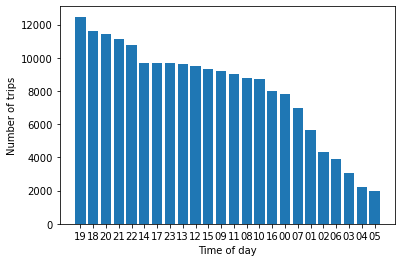

In [47]:
counts = merged_df_final['HOUR'].value_counts()
plt.bar(counts.index, counts.values)
plt.xticks(range(len(counts.index)))

plt.xlabel('Time of day')
plt.ylabel('Number of trips')

### 2. Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.

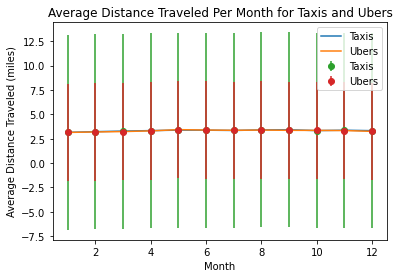

In [48]:
import matplotlib.pyplot as plt

# x-axis values (months)
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# y-axis values (average distance traveled)
# for taxis
y1 = df_yt_final.groupby(['month']).mean()['coord_distance'].to_list()
# for Ubers
y2 = df_filtered_uber.groupby(['month']).mean()['coord_distance'].to_list()

# plot lines for taxis and Ubers
plt.plot(x, y1, label="Taxis")
plt.plot(x, y2, label="Ubers")

# add error bars to show the 90% confidence interval around the mean
plt.errorbar(x, y1, yerr=10, fmt="o", label="Taxis")
plt.errorbar(x, y2, yerr=5, fmt="o", label="Ubers")

# add x-axis and y-axis labels
plt.xlabel("Month")
plt.ylabel("Average Distance Traveled (miles)")

# add a title to the plot
plt.title("Average Distance Traveled Per Month for Taxis and Ubers")

# show the legend
plt.legend()

# show the plot
plt.show()

### 3. Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport. 

Text(0, 0.5, 'Number of trips')

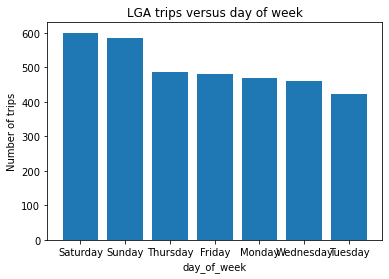

In [49]:
# Load the data into a pandas DataFrame
cols_to_select = ['End_Lon', 'End_Lat','day_of_week']
selected_df = merged_df_final.loc[:, cols_to_select]
cols_to_select2 = ['dropoff_longitude', 'dropoff_latitude','day_of_week']
selected_df2 = df_filtered_uber.loc[:, cols_to_select2]

df = pd.concat([selected_df,selected_df2.rename(columns={'dropoff_longitude':'End_Lon','dropoff_latitude':'End_Lat'})], ignore_index=True)
# Define the lat/long coordinate boxes around the airports using bboxfinder
lga_bbox = (-73.89, -73.75, 40.76, 40.66)
jfk_bbox = (-73.82, -73.76, 40.64, 40.58)
ewr_bbox = (-74.2, -74.05, 40.7, 40.62)

# Filter the data to only include drop offs within each airport's coordinate box
lga_data = df[(df['End_Lon'] >= lga_bbox[0]) & (df['End_Lon'] <= lga_bbox[1]) & (df['End_Lat'] >= lga_bbox[3]) & (df['End_Lat'] <= lga_bbox[2])]
jfk_data = df[(df['End_Lon'] >= jfk_bbox[0]) & (df['End_Lon'] <= jfk_bbox[1]) & (df['End_Lat'] >= jfk_bbox[3]) & (df['End_Lat'] <= jfk_bbox[2])]
ewr_data = df[(df['End_Lon'] >= ewr_bbox[0]) & (df['End_Lon'] <= ewr_bbox[1]) & (df['End_Lat'] >= ewr_bbox[3]) & (df['End_Lat'] <= ewr_bbox[2])]


counts_lga = lga_data['day_of_week'].value_counts()
plt.bar(counts_lga.index, counts_lga.values)
plt.xticks(range(len(counts_lga.index)))
plt.title("LGA trips versus day of week")
plt.xlabel('day_of_week')
plt.ylabel('Number of trips')

Text(0, 0.5, 'Number of trips')

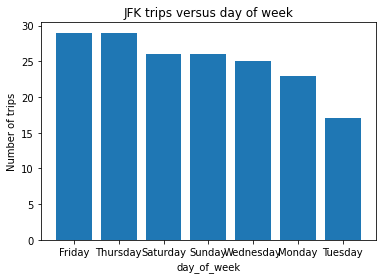

In [50]:
counts_jfk = jfk_data['day_of_week'].value_counts()
plt.bar(counts_jfk.index, counts_jfk.values)
plt.xticks(range(len(counts_jfk.index)))
plt.title("JFK trips versus day of week")
plt.xlabel('day_of_week')
plt.ylabel('Number of trips')

Text(0, 0.5, 'Number of trips')

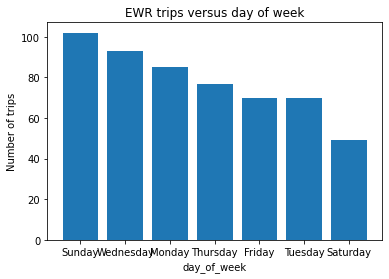

In [51]:
counts_ewr = ewr_data['day_of_week'].value_counts()
plt.bar(counts_ewr.index, counts_ewr.values)
plt.xticks(range(len(counts_ewr.index)))
plt.title("EWR trips versus day of week")
plt.xlabel('day_of_week')
plt.ylabel('Number of trips')

### 4. Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

In [52]:
df_filtered_uber

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,datetime,day_of_week,day,month,year,year_month,coord_distance
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,2015-05-07,Thursday,07,05,2015,2015-05,1.683
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2009-07-17,Friday,17,07,2009,2009-07,2.458
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,2009-08-24,Monday,24,08,2009,2009-08,5.036
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,2009-06-26,Friday,26,06,2009,2009-06,1.662
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,2014-08-28,Thursday,28,08,2014,2014-08,4.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1,2012-10-28,Sunday,28,10,2012,2012-10,0.112
199996,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1,2014-03-14,Friday,14,03,2014,2014-03,1.875
199997,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2,2009-06-29,Monday,29,06,2009,2009-06,12.850
199998,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1,2015-05-20,Wednesday,20,05,2015,2015-05,3.540


In [53]:
# This step will depend on how your data is formatted and stored
cols_to_select = ['Start_Lon', 'Start_Lat']
selected_df = merged_df_final.loc[:, cols_to_select]
cols_to_select2 = ['pickup_longitude', 'pickup_latitude']
selected_df2 = df_filtered_uber.loc[:, cols_to_select2]

df = pd.concat([selected_df,selected_df2.rename(columns={'pickup_longitude':'Start_Lon','pickup_latitude':'Start_Lat'})], ignore_index=True)

map = keplergl.KeplerGl()

map.add_data(df, "Hired Trips")

# Finally, we can display the map using the "show()" method
map.show()


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [54]:
map

KeplerGl(data={'Hired Trips': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…

### 5. Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.

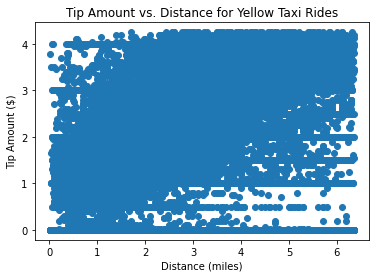

In [55]:
# x-axis values (distance)
x = df_yt_final['Trip_Distance'].to_list()

# y-axis values (tip amount)
y = df_yt_final['Tip_Amt'].to_list()

tuples = list(zip(x, y))

# calculate the interquartile range (IQR)
q1_x, q3_x = np.percentile(x, [25, 75])
iqr_x = q3_x - q1_x

q1_y, q3_y = np.percentile(y, [25, 75])
iqr_y = q3_y - q1_y
# remove any outliers outside of the IQR range
tuples = [val for val in tuples if val[0] >= q1_x - 1.5*iqr_x and val[0] <= q3_x + 1.5*iqr_x and val[1] >= q1_y - 1.5*iqr_y and val[1] <= q3_y + 1.5*iqr_y]
# plot the data as a scatter plot
plt.scatter([x[0] for x in tuples], [x[1] for x in tuples])

# add x-axis and y-axis labels
plt.xlabel("Distance (miles)")
plt.ylabel("Tip Amount ($)")

# add a title to the plot
plt.title("Tip Amount vs. Distance for Yellow Taxi Rides")

# show the plot
plt.show()



### 6. Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.

In [56]:
df_weather_daily

,DailyPrecipitation,DailyWindSpeed
datetime,,
2009-01-01,0.000000e+00,11.041667
2009-01-02,9.000000e-07,6.593750
2009-01-03,1.000000e-07,9.875000
2009-01-04,0.000000e+00,7.370370
2009-01-05,1.000000e-07,6.925926
...,...,...
2015-12-27,1.700001e-01,4.604167
2015-12-28,3.000030e-02,7.576923
2015-12-29,9.300005e-01,7.625000


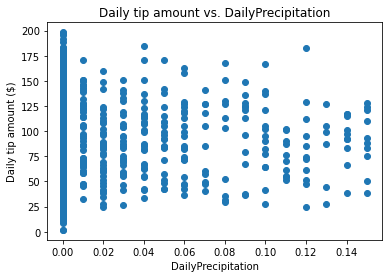

In [57]:
# x-axis values (DailyPrecipitation)
x = df_weather_daily['DailyPrecipitation']

# y-axis values (Daily tip amount)
y = df_yt_final.groupby(['date']).sum()['Tip_Amt']

tuples = list(zip(x, y))

# calculate the interquartile range (IQR)
q1_x, q3_x = np.percentile(x, [25, 75])
iqr_x = q3_x - q1_x

q1_y, q3_y = np.percentile(y, [25, 75])
iqr_y = q3_y - q1_y

# remove any outliers outside of the IQR range
tuples = [val for val in tuples if val[0] >= q1_x - 1.5*iqr_x and val[0] <= q3_x + 1.5*iqr_x and val[1] >= q1_y - 1.5*iqr_y and val[1] <= q3_y + 1.5*iqr_y]

# plot the data as a scatter plot
plt.scatter([x[0] for x in tuples], [x[1] for x in tuples])

# add x-axis and y-axis labels
plt.xlabel("DailyPrecipitation")
plt.ylabel("Daily tip amount ($)")

# add a title to the plot
plt.title("Daily tip amount vs. DailyPrecipitation")

# show the plot
plt.show()


## Create SQL File

In [1]:
# create SQL file for Part 2 schema
filedata = """
CREATE TABLE "Yellow_Taxi_trip" (
	"index" BIGINT, 
	"Trip_Pickup_DateTime" TEXT, 
	"Trip_Dropoff_DateTime" TEXT, 
	"Passenger_Count" BIGINT, 
	"Trip_Distance" FLOAT, 
	"Start_Lon" FLOAT, 
	"Start_Lat" FLOAT, 
	"End_Lon" FLOAT, 
	"End_Lat" FLOAT, 
	"Fare_Amt" FLOAT, 
	"Tip_Amt" FLOAT, 
	coord_distance FLOAT, 
	date TEXT, 
	day_of_week TEXT, 
	"HOUR" BIGINT, 
	day BIGINT, 
	month BIGINT, 
	year BIGINT, 
	year_month TEXT
)

CREATE TABLE "Uber_trip" (
	"index" BIGINT, 
	"key" TEXT, 
	fare_amount FLOAT, 
	pickup_datetime TEXT, 
	pickup_longitude FLOAT, 
	pickup_latitude FLOAT, 
	dropoff_longitude FLOAT, 
	dropoff_latitude FLOAT, 
	passenger_count BIGINT, 
	datetime DATETIME, 
	day_of_week TEXT, 
	day TEXT, 
	month TEXT, 
	year TEXT, 
	year_month TEXT, 
	coord_distance FLOAT
)

CREATE TABLE hourly_weather (
	datetime TEXT, 
	"HOUR" TEXT, 
	"HourlyPrecipitation" FLOAT, 
	"HourlyWindSpeed" FLOAT, 
	"DailySustainedWindSpeed" FLOAT
)

CREATE TABLE daily_weather (
	"index" BIGINT, 
	"DAY" TEXT, 
	"DailyPrecipitation" FLOAT, 
	"DailyWindSpeed" FLOAT
)

CREATE TABLE daily_weather (
	datetime TEXT, 
	"DailyPrecipitation" FLOAT, 
	"DailyWindSpeed" FLOAT
)
"""

In [2]:
with open('schema.sql', 'w') as file:
  file.write(filedata)

In [3]:
# create sql files for Part 3 queries

In [4]:
filedata1 = "SELECT COUNT(*) FROM Yellow_Taxi_trip GROUP BY HOUR"
with open('query1.sql', 'w') as file:
  file.write(filedata1)

In [5]:
filedata2 = "SELECT day_of_week ,COUNT(*) FROM Uber_Trip GROUP BY day_of_week ORDER BY COUNT(*) DESC"
with open('query2.sql', 'w') as file:
  file.write(filedata2)

In [6]:
filedata3 = """
SELECT count(*) FROM Yellow_Taxi_trip
UNION ALL
SELECT count(*) FROM Uber_trip


SELECT 
            coord_distance
            FROM Yellow_Taxi_trip
            UNION ALL
            SELECT coord_distance 
            FROM Uber_trip
            ORDER BY coord_distance DESC
            LIMIT {n_95}
            
"""
with open('query3.sql', 'w') as file:
  file.write(filedata3)

In [7]:
filedata4 = """
SELECT date as DAY, COUNT(*) as count, AVG(coord_distance) as avg_distance
FROM Yellow_Taxi_trip
WHERE date like "2009%"
UNION
SELECT datetime as DAY, COUNT(*) as count, AVG(coord_distance) as avg_distance
FROM Uber_trip
WHERE datetime like "2009%"
GROUP BY DAY
ORDER BY count DESC
LIMIT 10
                """
with open('query4.sql', 'w') as file:
  file.write(filedata4)

In [8]:
filedata5 = """SELECT 
                datetime
                FROM daily_weather
                WHERE datetime like '2014%'
                ORDER BY DailyWindSpeed DESC
                LIMIT 10 
                """
with open('query5.sql', 'w') as file:
  file.write(filedata5)